<a href="https://colab.research.google.com/github/DPK-VT/MLTESTS/blob/main/Currency_ECBTest5_W180_15days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
143/143 - 16s - 115ms/step - loss: 0.0547 - val_loss: 0.0010 - learning_rate: 1.0000e-03
Epoch 2/100
143/143 - 20s - 141ms/step - loss: 0.0086 - val_loss: 5.0648e-04 - learning_rate: 1.0000e-03
Epoch 3/100
143/143 - 20s - 143ms/step - loss: 0.0064 - val_loss: 3.8350e-04 - learning_rate: 1.0000e-03
Epoch 4/100
143/143 - 20s - 141ms/step - loss: 0.0051 - val_loss: 3.6894e-04 - learning_rate: 1.0000e-03
Epoch 5/100
143/143 - 21s - 146ms/step - loss: 0.0042 - val_loss: 4.4169e-04 - learning_rate: 1.0000e-03
Epoch 6/100
143/143 - 20s - 142ms/step - loss: 0.0038 - val_loss: 3.7038e-04 - learning_rate: 1.0000e-03
Epoch 7/100
143/143 - 21s - 144ms/step - loss: 0.0034 - val_loss: 3.3917e-04 - learning_rate: 1.0000e-03
Epoch 8/100

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
143/143 - 20s - 142ms/step - loss: 0.0032 - val_loss: 3.3514e-04 - learning_rate: 1.0000e-03
Epoch 9/100
143/143 - 13s - 90ms/step - loss: 0.0031 - val_loss: 3.4154e-04 - learning_

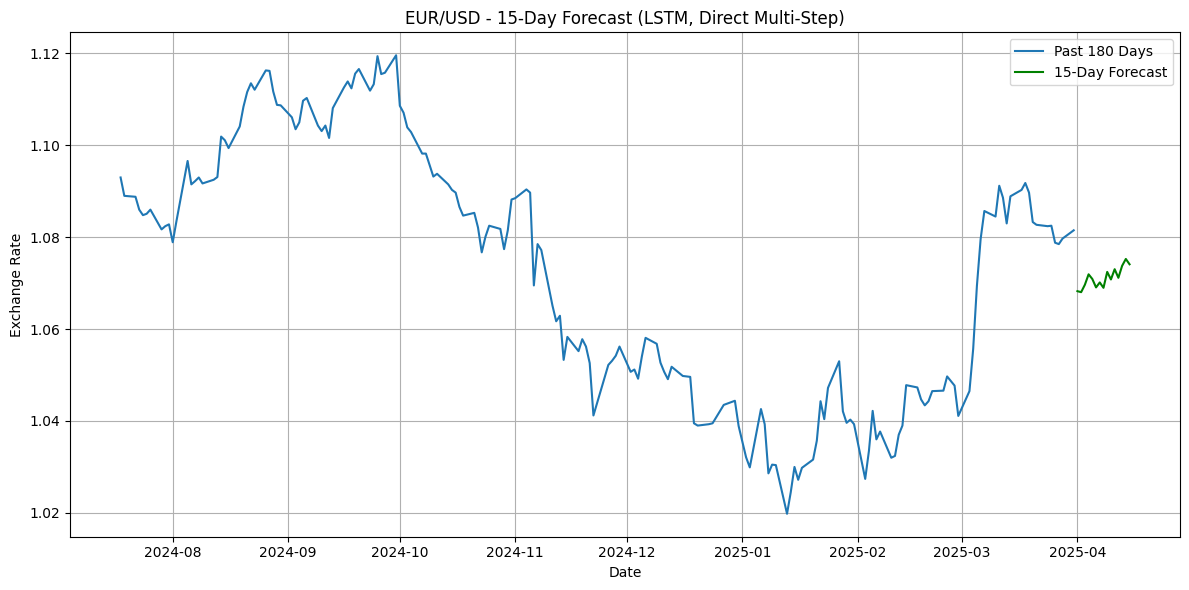

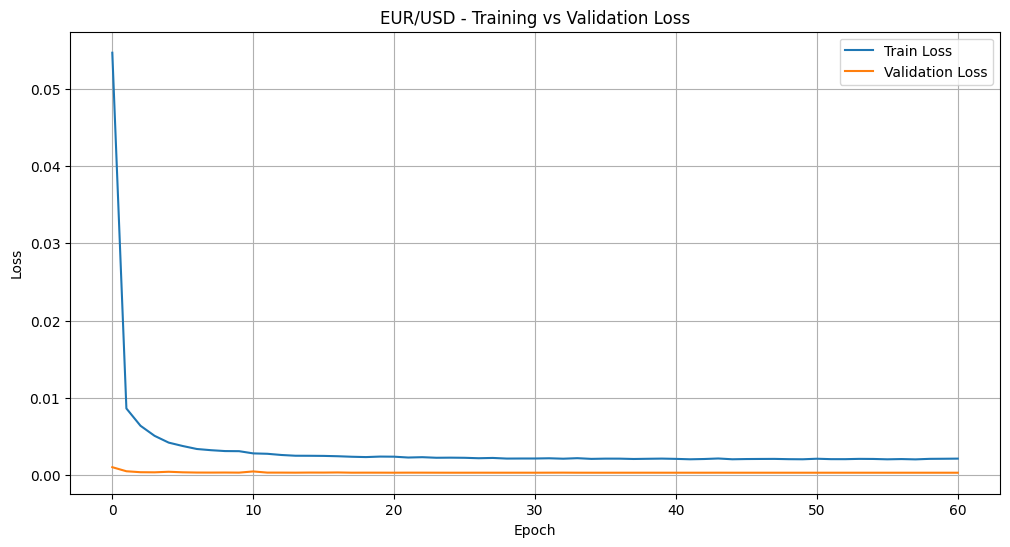

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Evaluation for EUR/USD
RMSE: 0.0138
MAE : 0.0103


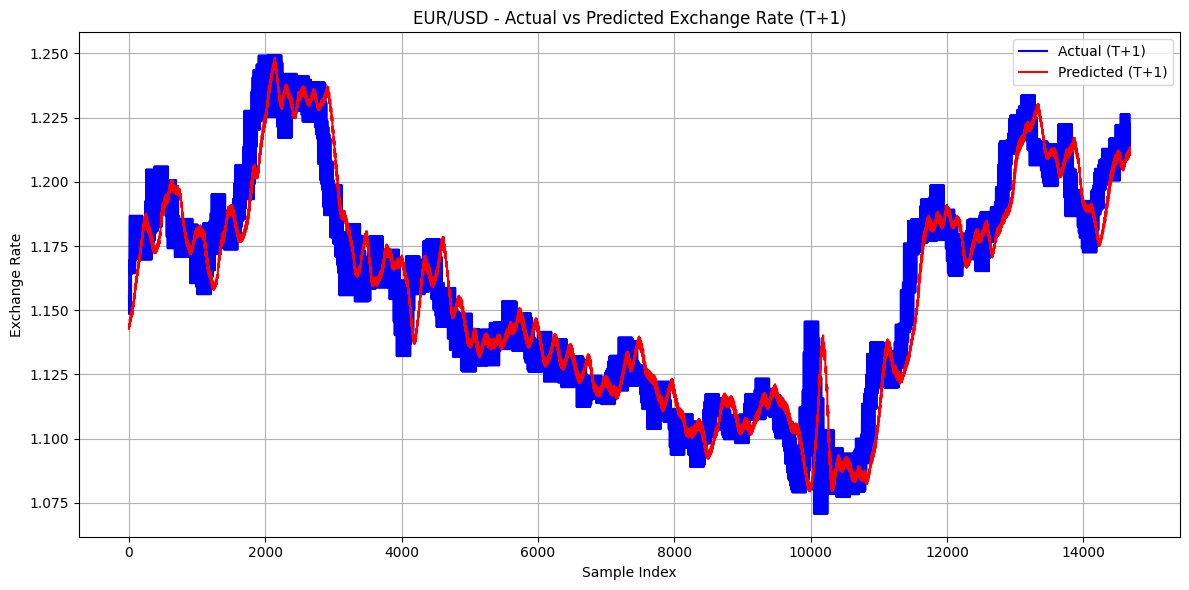

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

# --- Sequence creation for multi-output ---
def create_sequences_multi_output(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

# --- Parameters ---
window_size = 180
forecast_horizon = 15
currency = 'EUR/USD'  # change as needed

# --- Load and preprocess data ---
data = pd.read_excel("ECB_exchange_rates_march31.xlsx", index_col="Date", parse_dates=True)  # replace with your file path
df = data[[currency]].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# --- Create sequences ---
X, y = create_sequences_multi_output(scaled_data, window_size, forecast_horizon)

# --- Train/val/test split ---
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# --- Reshape for LSTM ---
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_val = X_val.reshape((X_val.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

# --- Define LSTM model ---
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(forecast_horizon)
])
model.compile(optimizer='adam', loss='mse')

# --- Train model with callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

# --- Forecast future values ---
forecast_input = X_test[-1].reshape(1, window_size, 1)
forecast = model.predict(forecast_input)[0]  # shape (15,)
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))

# --- Forecast dates ---
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

# --- Plot forecast ---
plt.figure(figsize=(12, 6))
plt.plot(df.index[-180:], df[currency].values[-180:], label='Past 180 Days')
plt.plot(future_dates, forecast.flatten(), label='15-Day Forecast', color='green')
plt.title(f"{currency} - 15-Day Forecast (LSTM, Direct Multi-Step)")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save model and scaler ---
model.save(f"{currency.replace('/', '_')}_lstm_model.keras")
joblib.dump(scaler, f"{currency.replace('/', '_')}_scaler.pkl")

# === Evaluation and Visualization ===

# Plot training/validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{currency} - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inverse transform predictions and actuals
#val_predictions = model.predict(X_val)
#predictions_inv = scaler.inverse_transform(val_predictions)
#actual_inv = scaler.inverse_transform(y_val)

# Inverse transform predictions and actuals
val_predictions = model.predict(X_val)
predictions_inv = scaler.inverse_transform(val_predictions.reshape(-1, 1)) # Reshape predictions
actual_inv = scaler.inverse_transform(y_val.reshape(-1, 1)) # Reshape actual values

# Calculate metrics (overall for all forecast steps)
rmse = np.sqrt(mean_squared_error(actual_inv.flatten(), predictions_inv.flatten()))
mae = mean_absolute_error(actual_inv.flatten(), predictions_inv.flatten())
print(f"\nEvaluation for {currency}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# Plot for the first forecast step (T+1)
plt.figure(figsize=(12, 6))
plt.plot(actual_inv[:, 0], label='Actual (T+1)', color='blue')
plt.plot(predictions_inv[:, 0], label='Predicted (T+1)', color='red')
plt.title(f'{currency} - Actual vs Predicted Exchange Rate (T+1)')
plt.xlabel('Sample Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()